# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import seaborn as sns

%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [75]:
# Show df_content to get an idea of the data
df_content.head()
df_content

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4
...,...,...,...,...,...
1051,PouchDB-find is a new API and syntax that allo...,PouchDB uses MapReduce as its default search m...,A look under the covers of PouchDB-find,Live,1046
1052,We compare discriminative and generative learn...,We compare discriminative and generative learn...,A comparison of logistic regression and naive ...,Live,1047
1053,"Essays about data, building products and boots...",In order to demystify some of the magic behind...,What I Learned Implementing a Classifier from ...,Live,1048
1054,NaN,Learn how to use IBM dashDB as data store for ...,Use dashDB with Spark,Live,1049


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [76]:

#get the amount of article read by user
grouped_df = df.groupby(by = "email").count()
#around 9 users read per person
grouped_df

,article_id,title
email,,
0000b6387a0366322d7fbfc6434af145adf7fed1,13,13
001055fc0bb67f71e8fa17002342b256a30254cd,4,4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621,3,3
001a852ecbd6cc12ab77a785efa137b2646505fe,6,6
001fc95b90da5c3cb12c501d201a915e4f093290,2,2
...,...,...
ffc6cfa435937ca0df967b44e9178439d04e3537,2,2
ffc96f8fbb35aac4cb0029332b0fc78e7766bb5d,4,4
ffe3d0543c9046d35c2ee3724ea9d774dff98a32,32,32


Text(0, 0.5, 'Amount of users')

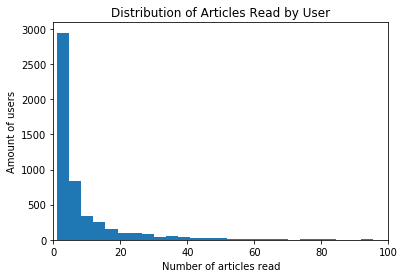

In [77]:
#use a histogram to see the distribution of articles read by user
articles = grouped_df["article_id"].values
ax = plt.hist(articles,bins = 100)
plt.title("Distribution of Articles Read by User")
plt.xlim([0,100])
plt.xlabel("Number of articles read")
plt.ylabel("Amount of users")

In [78]:
grouped_df.describe

<bound method NDFrame.describe of                                           article_id  title
email                                                      
0000b6387a0366322d7fbfc6434af145adf7fed1          13     13
001055fc0bb67f71e8fa17002342b256a30254cd           4      4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621           3      3
001a852ecbd6cc12ab77a785efa137b2646505fe           6      6
001fc95b90da5c3cb12c501d201a915e4f093290           2      2
...                                              ...    ...
ffc6cfa435937ca0df967b44e9178439d04e3537           2      2
ffc96f8fbb35aac4cb0029332b0fc78e7766bb5d           4      4
ffe3d0543c9046d35c2ee3724ea9d774dff98a32          32     32
fff9fc3ec67bd18ed57a34ed1e67410942c4cd81          10     10
fffb93a166547448a0ff0232558118d59395fecd          13     13

[5148 rows x 2 columns]>

In [79]:
# Fill in the median and maximum number of user_article interactios below
median_val = grouped_df['title'].median() # 50% of individuals interact with 3 number of articles or fewer.
max_views_by_user = grouped_df['title'].max()# The maximum number of user-article interactions by any 1 user is 364.
print(median_val,max_views_by_user)

3.0 364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [80]:
# Find and explore duplicate articles
duplicates = df_content[df_content.duplicated(subset = ["article_id"])]
duplicates

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [81]:
# Remove any rows that have the same article_id - only keep the first
dupes_dropped = df_content.drop_duplicates(subset=['article_id'])
dupes_dropped.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [82]:
#unique articles 
articles_df = df.groupby(by = "article_id").count()
unique_articles = articles_df[articles_df["title"] > 1]
unique_articles

,title,email
article_id,,
0.0,14,14
2.0,58,58
4.0,13,13
8.0,85,85
9.0,10,10
...,...,...
1440.0,10,10
1441.0,8,8
1442.0,4,4


In [83]:
unique_articles = len(articles_df[articles_df["title"] >= 1]) # The number of unique articles that have at least one interaction
total_articles = dupes_dropped.shape[0]# The number of unique articles on the IBM platform
unique_users = grouped_df.shape[0]# The number of unique users
user_article_interactions = df.shape[0]# The number of user-article interactions

45976

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [84]:
most_viewed_article_id =str(articles_df[articles_df["title"] == articles_df.max()['title']].index.values[0])# The most viewed article in the dataset as a string with one value following the decimal 
max_views =articles_df.max()['title'] # The most viewed article in the dataset was viewed how many times?

In [85]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [86]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


## Part II: Rank-Based Recommendations

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [87]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    articles_df = df.groupby(by = "title").count()
    #sort the df
    sorted_df = articles_df.sort_values(by = "user_id",ascending = False)

    #grab top n id results
    top_articles = sorted_df.iloc[:n].index
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    articles_df = df.groupby(by = "article_id").count()

    #sort the df
    sorted_df = articles_df.sort_values(by = "user_id",ascending = False)

    #grab top n id results
    top_articles = sorted_df.iloc[:n].index.tolist()
 
    return top_articles # Return the top article ids

In [88]:
print(get_top_articles(10))
print(get_top_article_ids(10))

Index(['use deep learning for image classification',
       'insights from new york car accident reports',
       'visualize car data with brunel',
       'use xgboost, scikit-learn & ibm watson machine learning apis',
       'predicting churn with the spss random tree algorithm',
       'healthcare python streaming application demo',
       'finding optimal locations of new store using decision optimization',
       'apache spark lab, part 1: basic concepts',
       'analyze energy consumption in buildings',
       'gosales transactions for logistic regression model'],
      dtype='object', name='title')
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [89]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [90]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    grouped_df = df.groupby(by = ['user_id','article_id'],as_index = False).count().pivot(index = "user_id",columns = "article_id",values = "title")
    #taken from https://stackoverflow.com/questions/37543647/how-to-replace-all-non-nan-entries-of-a-dataframe-with-1-and-all-nan-with-0
    user_item = grouped_df.notnull().astype('int')
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)
print(user_item)

article_id  0.0     2.0     4.0     8.0     9.0     12.0    14.0    15.0    \
user_id                                                                      
1                0       0       0       0       0       0       0       0   
2                0       0       0       0       0       0       0       0   
3                0       0       0       0       0       1       0       0   
4                0       0       0       0       0       0       0       0   
5                0       0       0       0       0       0       0       0   
...            ...     ...     ...     ...     ...     ...     ...     ...   
5145             0       0       0       0       0       0       0       0   
5146             0       0       0       0       0       0       0       0   
5147             0       0       0       0       0       0       0       0   
5148             0       0       0       0       0       0       0       0   
5149             0       0       0       0       0       0      

In [91]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [92]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    #get user row
    user_row1 = user_item.loc[user_id]
    
    scores = {}
    # compute similarity of each user to the provided user
    for user in user_item.index:
        user_row2 = user_item.loc[user]
        scores[user] = np.dot(user_row1,user_row2)
    #delete user from dict
    del scores[user]
    # sort by similarity
    sorted_users_tups = sorted(list(scores.items()), key=lambda x: x[1],reverse = True)
    
    # create list of just the ids
    most_similar_users = [tup[0] for tup in sorted_users_tups]
  
       
    return most_similar_users,scores # return a list of the users in order from most to least similar
        

In [93]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[0][:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[0][:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[0][:3]))

The 10 most similar users to user 1 are: [1, 3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201]
The 5 most similar users to user 3933 are: [1, 3933, 23, 3782, 203]
The 3 most similar users to user 46 are: [46, 4201, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [94]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = df[df["article_id"].isin(article_ids)]["title"].tolist()
    #drop duplicates
    article_names = list(set(article_names))
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    user_row = user_item.loc[user_id]
    #fill a list with all articles that have a 1
    article_ids = [str(article) for article in user_item.columns if user_row[article] == 1]
    #get names
    article_names = get_article_names(article_ids)
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here

  
    #grab articles the user has read
    article_ids, article_names = get_user_articles(user_id)
    #grab similiar users
    users = find_similar_users(user_id)[0]
    recs = []
    #loop thru users
    for user in users:
        #grab articles the user has read
        article_ids2, article_names2 = get_user_articles(user)
        #loop thru articles and append the ones that the user hasnt read
        for article in article_ids2:
            if article not in article_ids and article not in recs:
                recs.append(article)
                
                #if we are at our max recommendation, just return the list
                if len(recs) == m:
                    return recs

    
    return recs # return your recommendations for this user_id    

In [95]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'graph-based machine learning',
 'using brunel in ipython/jupyter notebooks',
 'deep forest: towards an alternative to deep neural networks',
 'the 3 kinds of context: machine learning and the art of the frame',
 'experience iot with coursera',
 'this week in data science (april 18, 2017)',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook']

True

In [96]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [97]:
user_item.sum()[0.0]

12

In [140]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    #grab num interactions
    article_interactions = df.groupby(by = "user_id").count()["article_id"]
    #grab dict with user id and scores
    neighbors_dict = find_similar_users(user_id, user_item=user_item)[1]
    
    #grab list of ids and similarities
    
    neighbor_ids = neighbors_dict.keys()
    #remove user
    neighbor_ids = [neighbor for neighbor in neighbor_ids if neighbor != user_id]

    similarities = [neighbors_dict[neighbor] for neighbor in neighbor_ids] #grab out value from numpy array

    #get num interactions for each user 
    num_interactions = article_interactions.loc[neighbor_ids]

    #build df
    neighbors_df = pd.DataFrame(index = neighbor_ids)

    neighbors_df["similarity"] = similarities
    neighbors_df["num_interactions"] = num_interactions
    neighbors_df = neighbors_df.sort_values(by = ['similarity','num_interactions'],ascending = False)
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    #find amount of interactions per article
    article_interactions = df.groupby(by = "article_id").count()["user_id"]

    #set up recs list
    recs = []
    #grab articles the user has read
    article_ids, article_names = get_user_articles(user_id)
    #generate neighbors_df and loop thru each user
    neighbors_df = get_top_sorted_users(user_id)

    for user in neighbors_df.index:
        #grab articles the neighbor has read
        article_ids2, article_names2 = get_user_articles(user)
        #make a list of neighbour-specifc articles to sort at the end
        curr_recs = []
        #loop thru articles and append the ones that the user hasnt read
        for article in article_ids2:
            
            if article not in article_ids and article not in recs:
                curr_recs.append(article)
                
                #if we are at our max recommendation, just return the list
                if len(recs + curr_recs) == m:
                    #sort curr_recs by total article interactions, and add it
                    recs = recs + sorted(curr_recs, reverse = True, \
                        key = lambda x : article_interactions[float(x)])

                    return recs,get_article_names(recs)
        #sort curr_recs by total article interactions, and add it
        recs = recs + sorted(curr_recs, reverse = True, \
            key = lambda x : article_interactions[float(x)])
    
    return recs, get_article_names(recs)

In [141]:
user_item.sum()[0.0]

12

In [142]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['164.0', '109.0', '12.0', '125.0', '336.0', '362.0', '205.0', '465.0', '142.0', '302.0']

The top 10 recommendations for user 20 are the following article names:
["a beginner's guide to variational methods", 'introduction to neural networks, advantages and applications', 'learn tensorflow and deep learning together and now!', 'accelerate your workflow with dsx', 'dsx: hybrid mode', 'challenges in deep learning', 'tensorflow quick tips', 'neural networks for beginners: popular types and applications', 'statistics for hackers', 'timeseries data analysis of iot events by using jupyter notebook']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [143]:
print(get_top_sorted_users(1).head(1))

      similarity  num_interactions
3933          35                45


In [144]:
print(get_top_sorted_users(131).head(10))

      similarity  num_interactions
3870          74               144
3782          39               363
23            38               364
203           33               160
4459          33               158
98            29               170
3764          29               169
49            29               147
3697          29               145
242           25               148


In [103]:
### Tests with a dictionary of results

user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242

In [104]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**
We would only really be able to use get_top_article_ids, and recommend the most popular articles as we have no other info on the user

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [105]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(id) for id in get_top_article_ids(10)]# Your recommendations here



In [106]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [107]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [108]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [109]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [110]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [111]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

**Provide your response here.**
This is different then in the lesson for a few reasons. Reason 1 is that in the lesson, we were using the 3 matrices to get the prediction matrix, here we are doing it vice versa. Also, the lesson explored sparse matrices, and using FunkSVD, which was not done here

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

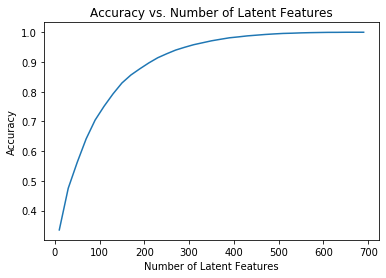

In [112]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [113]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [114]:
user_item_train.index.isin(test_idx).sum()

20

In [115]:
len(test_idx) - user_item_train.index.isin(test_idx).sum()

662

In [116]:
user_item_train.columns.isin(test_arts).sum()

574

In [117]:
len(test_arts) - user_item_train.columns.isin(test_arts).sum()

0

In [118]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?':c , 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [119]:
#CODE INSPIRED BY https://github.com/AlexanderHipp/recommendation-engine-IBM-master-udacity-project|

In [120]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [121]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
u_test = u_train[user_item_train.index.isin(test_idx), :]
vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]


In [122]:
u_test.shape

(20, 4487)

In [123]:
vt_test.shape

(714, 574)

In [124]:
from sklearn.metrics import accuracy_score

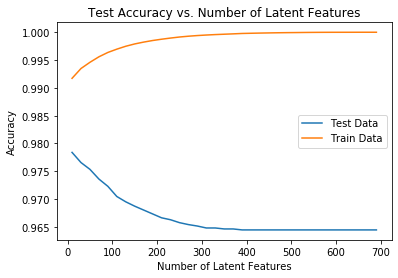

In [125]:
num_latent_feats = np.arange(10,700+10,20)
test_errs = []
train_errs = []
for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    # take dot product
    user_item_est_train = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    
    user_item_est_test = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    filtered_item_test = user_item_test.loc[user_item_test.index.isin(user_item_train.index)]
    # compute error for each prediction to actual value
    train_err = accuracy_score(user_item_train.values.flatten(), user_item_est_train.flatten())
    test_err = accuracy_score(filtered_item_test.values.flatten(), user_item_est_test.flatten())
    train_errs.append(train_err)
    test_errs.append(test_err)

    # total errors and keep track of them
    
    
plt.plot(num_latent_feats, test_errs);
plt.plot(num_latent_feats, train_errs);
plt.legend(["Test Data", "Train Data"])
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Test Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 


**Your response here.**
It seems that test accuracy goes down as the number of latent features increases, this is likely due to more latent features overfitting the data. 

*Is accuracy a good metric to use here in this case? Does it provide us with a fair assessment of the model's performance?*

Accuracy is not a good metric here, and it does not provide a fair assessment of the model's performance.
Since there are alot more 0's then 1's in the user matrix, getting that high accuracy could be as easy as guessing most things 0. It might be better to use precision or recall here instead.

*Is the current assessment framework robust enough to make conclusive results about the model? Think about the number of train and test users. How many users exist in your test set for whom you can make predictions? Is it sufficient? Should we really give up on SVD based on the current assessment and focus on other recommendation techniques?*

We really do not have enough common users betweem the test and train sets (only 20) and enough predictions to take advantage of SVD. It would be a better idea to look at other ways of recommendation like content based and collaborative based.


*Is there any other way to evaluate our model? Can we use an online evaluation technique like A/B testing? If yes, how will you go about setting one? What metrics will we need to track? How long will we run the experiment?*

We could evaluate our model using A/B testing by launching a new feature and seeing how well it does at predicting what users will interact with the articles. The new feature we would launch would be adding content-based filtering, guessing what articles users may like from key words in the article title. The metrics we could use would be precision, recall, and f1-score, as that would give us a metric focused on getting true postives, what we really care about. If we see that we are recommending articles the user would have liked, that means we are doing a good job. The business goal of this feature would be to keep clients on the site for longer by offering better recommendations, allowing us to make more revenue thru advertisement


<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [126]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0